**Next**

1. Time plot: only one station
2. Time plot: plot all stations and normalize (new stations are added along the way)
3. Correlation plots including distance (different distance measures; does distance impact correlation?)
4. New plot: rain vs count


In [17]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# allow imports from src/
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

# import dataloader function
from src.data.dataload import load_csv_folder_to_dataframe

In [18]:
DATA_DIR = PROJECT_ROOT / "data/raw"
PLOTS_DIR = PROJECT_ROOT / "outputs/plots"

In [19]:
##########################
# load data to dataframe #
##########################

df_loaded = load_csv_folder_to_dataframe(DATA_DIR)

Loading CSV files: 100%|██████████| 154/154 [02:40<00:00,  1.04s/file]


Load summary
- Files loaded: 154
- Total rows: 6122719
- Date range: 2012-12-31 23:00:00+00:00 to 2025-10-31 21:00:00+00:00
- Unique stations: 136


In [20]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

plt.rcParams['font.family'] = 'serif'  # oder 'sans-serif', 'monospace'
plt.rcParams['font.serif'] = ['Times New Roman']  # spezifischer Font
plt.rcParams['font.size'] = 25  # Basis-Schriftgröße
plt.rcParams['axes.titlesize'] = 25  # Titel-Größe
plt.rcParams['axes.labelsize'] = 25  # Achsenbeschriftung
plt.rcParams['xtick.labelsize'] = 25  # X-Achsen Tick Labels
plt.rcParams['ytick.labelsize'] = 25  # Y-Achsen Tick Labels
plt.rcParams['legend.fontsize'] = 25  # Legende

**(1) Monthly bike count for one station**  
Goal: Observe trend without effect of adding stations along the way  
Example: Radtunnel station Tübingen over long time period

C:\Users\matth\AppData\Local\Temp\ipykernel_9192\2578148882.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  station_data['year_month'] = station_data['iso_timestamp'].dt.to_period('M')


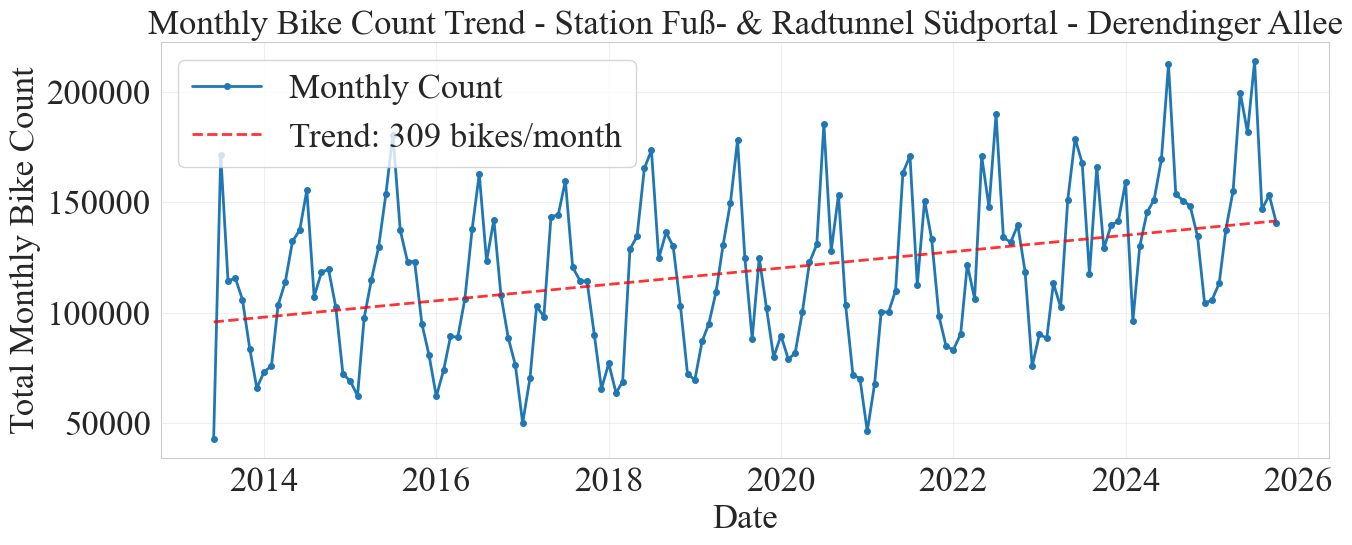

Station ID: 100003358
Station Name: Fuß- & Radtunnel Südportal - Derendinger Allee
Data range: 2013-06-20 22:00:00+00:00 to 2025-10-31 01:00:00+00:00
Total months: 149
Average monthly count: 118713


In [21]:
################################################
# Monthly Trend for Station 100003358          #
################################################

# Filter data for the specific station
station_data = df_loaded[df_loaded['counter_site_id'] == 100003358].copy()

if len(station_data) > 0:
    # Get station name
    station_name = station_data['counter_site'].iloc[0]
    
    # Create year_month column if not exists
    station_data['year_month'] = station_data['iso_timestamp'].dt.to_period('M')
    
    # Calculate monthly totals
    monthly_totals = station_data.groupby('year_month')['channels_all'].sum()
    monthly_totals.index = monthly_totals.index.to_timestamp()
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(monthly_totals.index, monthly_totals.values, linewidth=2, marker='o', markersize=4, label='Monthly Count')
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Monthly Bike Count')
    ax.set_title(f'Monthly Bike Count Trend - Station {station_name}')
    ax.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(range(len(monthly_totals)), monthly_totals.values, 1)
    p = np.poly1d(z)
    ax.plot(monthly_totals.index, p(range(len(monthly_totals))), 
            "r--", alpha=0.8, linewidth=2, label=f'Trend: {z[0]:.0f} bikes/month')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Station ID: 100003358")
    print(f"Station Name: {station_name}")
    print(f"Data range: {station_data['iso_timestamp'].min()} to {station_data['iso_timestamp'].max()}")
    print(f"Total months: {len(monthly_totals)}")
    print(f"Average monthly count: {monthly_totals.mean():.0f}")
else:
    print("No data found for station with counter_site_id 100003358")

**(2) Bike trend over time with added stations but normalized (by number of stations in each datum)**  

- Goal: See trend although sations are added
- Visible downward trend might be due to stations being added in locations with less bikes coming through (i.e. first stations were put in locations with largest amounts of bikers coming through, so addind stations leads to lower average)

C:\Users\matth\AppData\Local\Temp\ipykernel_9192\1090594694.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_temp['year_month'] = df_temp['iso_timestamp'].dt.to_period('M')


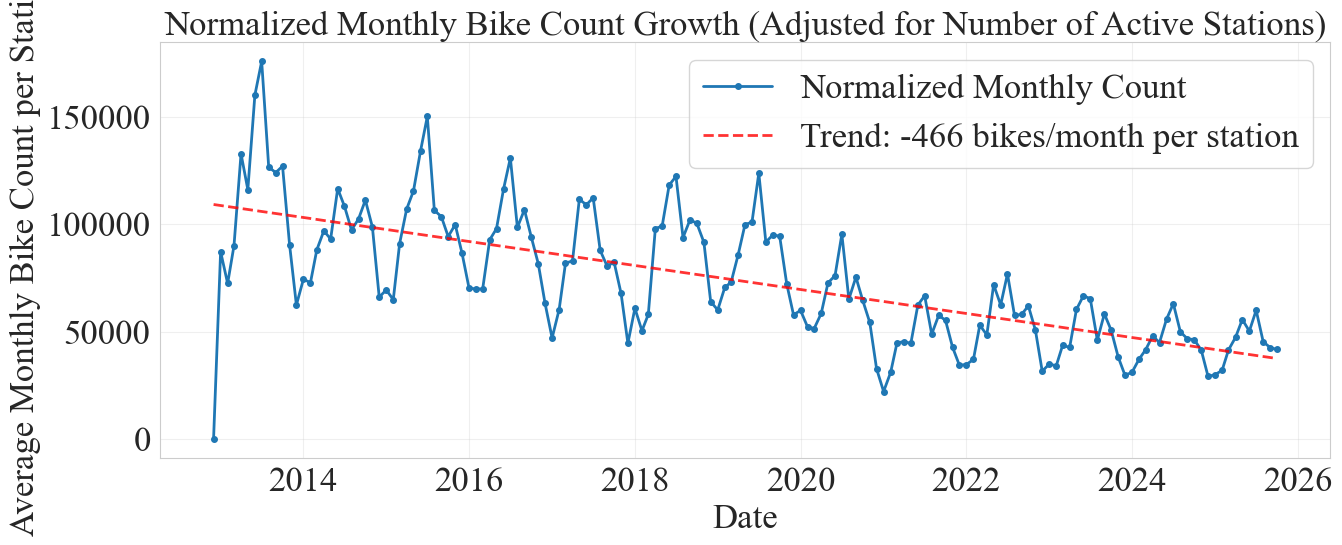

Total months: 155
Average bikes per station per month: 73340
Trend (change per month): -466.02 bikes/month per station


In [22]:
################################################
# Normalized Monthly Trend (All Stations)      #
################################################

# Calculate monthly totals and number of active stations per month
df_temp = df_loaded.copy()
df_temp['year_month'] = df_temp['iso_timestamp'].dt.to_period('M')

# Monthly totals across all stations
monthly_totals_all = df_temp.groupby('year_month')['channels_all'].sum()

# Count active stations per month (stations with at least one record that month)
active_stations_per_month = df_temp.groupby('year_month')['counter_site'].nunique()

# Normalize: divide total by number of active stations
monthly_normalized = monthly_totals_all / active_stations_per_month

# Convert index to timestamp for plotting
monthly_normalized.index = monthly_normalized.index.to_timestamp()

# Create plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(monthly_normalized.index, monthly_normalized.values, linewidth=2, marker='o', markersize=4, label='Normalized Monthly Count')
ax.set_xlabel('Date')
ax.set_ylabel('Average Monthly Bike Count per Station')
ax.set_title('Normalized Monthly Bike Count Growth (Adjusted for Number of Active Stations)')
ax.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(range(len(monthly_normalized)), monthly_normalized.values, 1)
p = np.poly1d(z)
ax.plot(monthly_normalized.index, p(range(len(monthly_normalized))), 
        "r--", alpha=0.8, linewidth=2, label=f'Trend: {z[0]:.0f} bikes/month per station')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Total months: {len(monthly_normalized)}")
print(f"Average bikes per station per month: {monthly_normalized.mean():.0f}")
print(f"Trend (change per month): {z[0]:.2f} bikes/month per station")

**(2b) Alternative to (2): Using three large stations over long time period when all were active, displaying average**  
Goal: Observe trend over time that is not subject to the normalization problem in (2) but uses more than one station for power

C:\Users\matth\AppData\Local\Temp\ipykernel_9192\384818053.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  stations_data['year_month'] = stations_data['iso_timestamp'].dt.to_period('M')


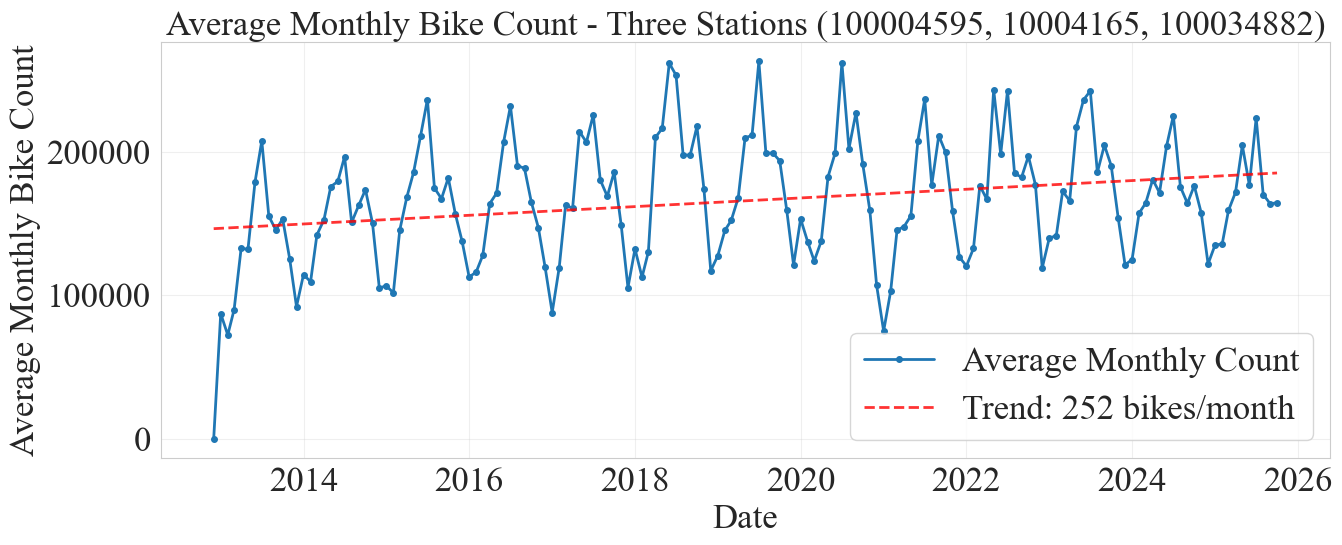

Stations included:
  - ID 100004595: Wiwilibrücke
  - ID 100004165: Erbprinzenstraße
  - ID 100034882: König-Karls-Brücke Barometer

Total months: 155
Average monthly count (across three stations): 165860
Trend (change per month): 251.95 bikes/month


In [23]:
################################################
# Average of Three Stations Over Time          #
################################################

# Define the three station IDs
station_ids = [100004595, 100004165, 100034882]

# Filter data for these stations
stations_data = df_loaded[df_loaded['counter_site_id'].isin(station_ids)].copy()

if len(stations_data) > 0:
    # Create year_month column
    stations_data['year_month'] = stations_data['iso_timestamp'].dt.to_period('M')
    
    # Calculate monthly totals for each station
    monthly_by_station = stations_data.groupby(['year_month', 'counter_site_id'])['channels_all'].sum().unstack(fill_value=0)
    
    # Calculate the average across the three stations
    monthly_avg = monthly_by_station.mean(axis=1)
    
    # Convert index to timestamp for plotting
    monthly_avg.index = monthly_avg.index.to_timestamp()
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(monthly_avg.index, monthly_avg.values, linewidth=2, marker='o', markersize=4, label='Average Monthly Count')
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Monthly Bike Count')
    ax.set_title('Average Monthly Bike Count - Three Stations (100004595, 10004165, 100034882)')
    ax.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(range(len(monthly_avg)), monthly_avg.values, 1)
    p = np.poly1d(z)
    ax.plot(monthly_avg.index, p(range(len(monthly_avg))), 
            "r--", alpha=0.8, linewidth=2, label=f'Trend: {z[0]:.0f} bikes/month')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print station names
    print("Stations included:")
    for station_id in station_ids:
        station_name = stations_data[stations_data['counter_site_id'] == station_id]['counter_site'].iloc[0] if len(stations_data[stations_data['counter_site_id'] == station_id]) > 0 else "Not found"
        print(f"  - ID {station_id}: {station_name}")
    
    print(f"\nTotal months: {len(monthly_avg)}")
    print(f"Average monthly count (across three stations): {monthly_avg.mean():.0f}")
    print(f"Trend (change per month): {z[0]:.2f} bikes/month")
else:
    print("No data found for the specified station IDs")

**(3) Rain vs count**  
Took hourly rain accumulation and bike count from three stations and showing 10k samples from this distribution, as well as averages over bins of size .5mm (one red dot is average of e.g. interval [0mm,.5mm).   
Careful: Less bikes at night, is rain equally likely at day or night? Rain-temp interaction?  
-> exploratory plot


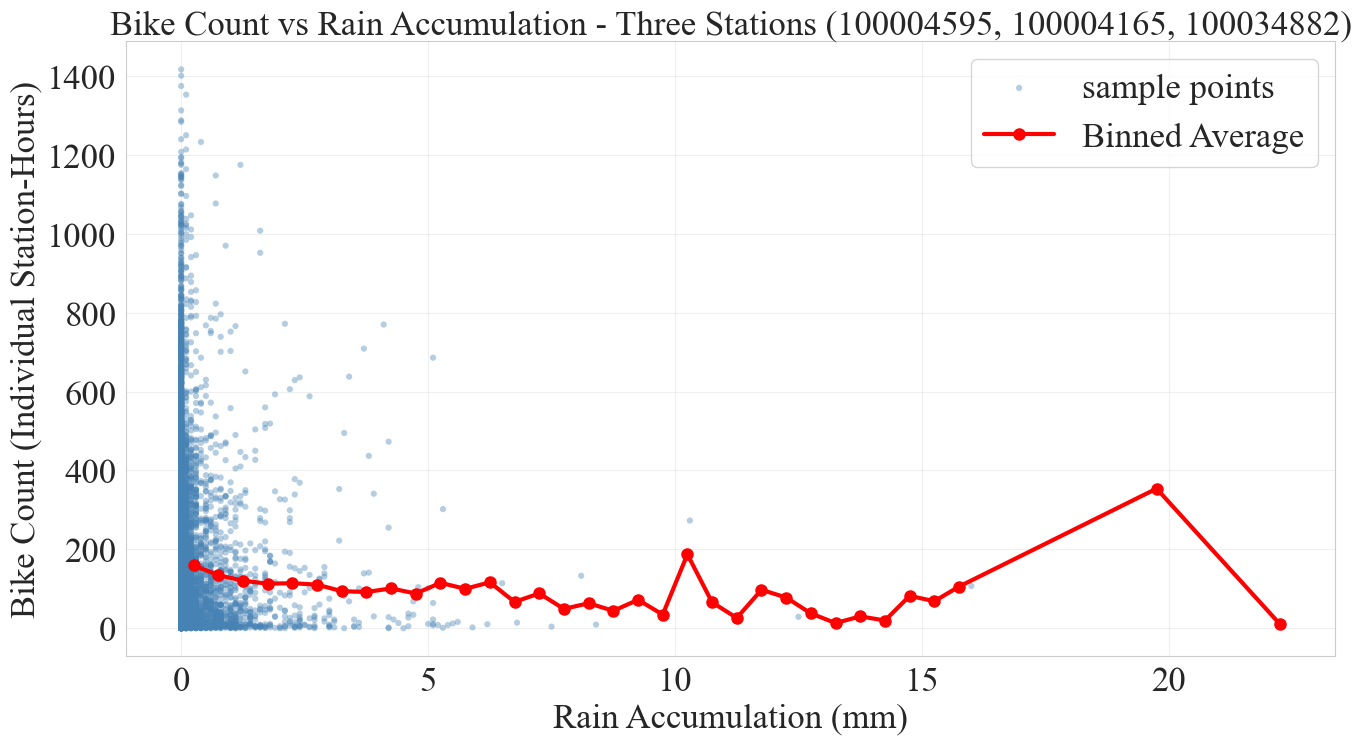

Correlation (rain vs bike count): -0.078
Average bike count (no rain): 189.2
Average bike count (with rain): 148.5
Impact of rain: -21.5%
Total data points: 248,210


In [24]:
################################################
# Rain vs Bike Count - Three Stations          #
################################################

# Define the three station IDs
station_ids = [100004595, 100004165, 100034882]

# Filter data for these stations
stations_data = df_loaded[df_loaded['counter_site_id'].isin(station_ids)].copy()

if len(stations_data) > 0:
    # Use individual data points (no aggregation by timestamp)
    hourly_data = stations_data[['site_rain_accumulation', 'channels_all']].dropna()
    
    # Create scatter plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Sample if too many points
    if len(hourly_data) > 10000:
        sample_data = hourly_data.sample(n=10000, random_state=42)
    else:
        sample_data = hourly_data
    
    scatter = ax.scatter(sample_data['site_rain_accumulation'], 
                        sample_data['channels_all'],
                        alpha=0.4, s=20, c='steelblue', edgecolors='none', label='sample points')
    
    ax.set_xlabel('Rain Accumulation (mm)')
    ax.set_ylabel('Bike Count (Individual Station-Hours)')
    ax.set_title('Bike Count vs Rain Accumulation - Three Stations (100004595, 100004165, 100034882)')
    ax.grid(True, alpha=0.3)
    
    # Add binned average line
    # Create rain bins
    rain_bins = np.arange(0, hourly_data['site_rain_accumulation'].max() + 0.5, 0.5)
    hourly_data['rain_bin'] = pd.cut(hourly_data['site_rain_accumulation'], bins=rain_bins)
    binned_avg = hourly_data.groupby('rain_bin', observed=True)['channels_all'].mean()
    
    # Plot binned averages
    bin_centers = [(interval.left + interval.right) / 2 for interval in binned_avg.index]
    ax.plot(bin_centers, binned_avg.values, 'r-', linewidth=3, marker='o', 
            markersize=8, label='Binned Average', zorder=5)
    
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Statistics
    correlation = hourly_data[['site_rain_accumulation', 'channels_all']].corr().iloc[0, 1]
    no_rain = hourly_data[hourly_data['site_rain_accumulation'] == 0]['channels_all'].mean()
    with_rain = hourly_data[hourly_data['site_rain_accumulation'] > 0]['channels_all'].mean()
    
    print(f"Correlation (rain vs bike count): {correlation:.3f}")
    print(f"Average bike count (no rain): {no_rain:.1f}")
    print(f"Average bike count (with rain): {with_rain:.1f}")
    print(f"Impact of rain: {((with_rain/no_rain - 1) * 100):.1f}%")
    print(f"Total data points: {len(hourly_data):,}")
else:
    print("No data found for the specified station IDs")

**sanity check for last plot**

Total high-rain data points (>6mm): 235


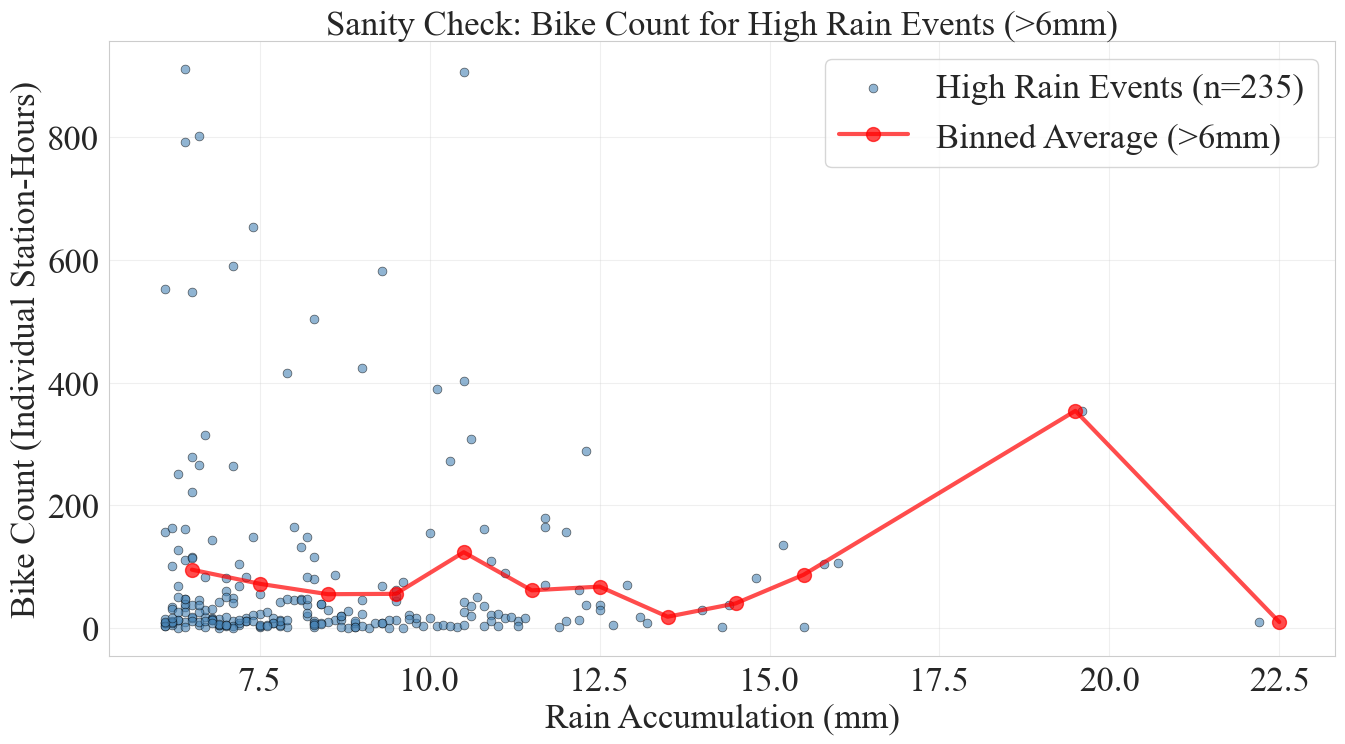


Statistics for rain >6mm:
  - Number of events: 235
  - Rain range: 6.10 - 22.20 mm
  - Bike count range: 0 - 910
  - Average bike count: 80.1
  - Median bike count: 20.0


In [25]:
################################################
# Sanity Check Plot: High Rain Events (>6mm)   #
################################################

# Define the three station IDs
station_ids = [100004595, 100004165, 100034882]

# Filter data for these stations
stations_data = df_loaded[df_loaded['counter_site_id'].isin(station_ids)].copy()

# Use individual data points
hourly_data = stations_data[['site_rain_accumulation', 'channels_all']].dropna()

# Filter for high rain events (>6mm)
high_rain_data = hourly_data[hourly_data['site_rain_accumulation'] > 6].copy()

print(f"Total high-rain data points (>6mm): {len(high_rain_data)}")

if len(high_rain_data) > 0:
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot ALL high-rain points (no sampling)
    ax.scatter(high_rain_data['site_rain_accumulation'], 
               high_rain_data['channels_all'],
               alpha=0.6, s=40, c='steelblue', edgecolors='black', linewidths=0.5,
               label=f'High Rain Events (n={len(high_rain_data)})')
    
    ax.set_xlabel('Rain Accumulation (mm)')
    ax.set_ylabel('Bike Count (Individual Station-Hours)')
    ax.set_title('Sanity Check: Bike Count for High Rain Events (>6mm)')
    ax.grid(True, alpha=0.3)
    
    # Add binned average line using ALL data (not just >6mm)
    rain_bins = np.arange(0, hourly_data['site_rain_accumulation'].max() + 1, 1)
    hourly_data['rain_bin'] = pd.cut(hourly_data['site_rain_accumulation'], bins=rain_bins)
    binned_avg = hourly_data.groupby('rain_bin', observed=True)['channels_all'].mean()
    
    # Plot only the bins that are >6mm
    bin_centers = [(interval.left + interval.right) / 2 for interval in binned_avg.index]
    bin_values = binned_avg.values
    
    # Filter to show only bins >6mm
    high_rain_bins = [(c, v) for c, v in zip(bin_centers, bin_values) if c > 6]
    if high_rain_bins:
        centers, values = zip(*high_rain_bins)
        ax.plot(centers, values, 'r-', linewidth=3, marker='o', 
                markersize=10, label='Binned Average (>6mm)', zorder=5, alpha=0.7)
    
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\nStatistics for rain >6mm:")
    print(f"  - Number of events: {len(high_rain_data)}")
    print(f"  - Rain range: {high_rain_data['site_rain_accumulation'].min():.2f} - {high_rain_data['site_rain_accumulation'].max():.2f} mm")
    print(f"  - Bike count range: {high_rain_data['channels_all'].min():.0f} - {high_rain_data['channels_all'].max():.0f}")
    print(f"  - Average bike count: {high_rain_data['channels_all'].mean():.1f}")
    print(f"  - Median bike count: {high_rain_data['channels_all'].median():.1f}")
else:
    print("No high-rain events (>6mm) found in the data")

**(4) Correlation analysis (exploratory)**

In [26]:
################################################
# Correlation vs Distance Analysis             #
################################################

# Step 1: Calculate pairwise distances between all stations using Haversine formula
from math import radians, cos, sin, asin, sqrt

def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    Returns distance in kilometers
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers
    r = 6371
    
    return c * r

# Get unique station info (station name, lat, lon)
station_info = df_loaded.groupby('counter_site').agg({
    'latitude': 'first',
    'longitude': 'first'
}).dropna()

print(f"Number of stations with location data: {len(station_info)}")
print(f"\nFirst few stations:")
print(station_info.head())

# Calculate all pairwise distances
stations = station_info.index.tolist()
n_stations = len(stations)

distance_matrix = pd.DataFrame(0.0, index=stations, columns=stations)

for i, station1 in enumerate(stations):
    for j, station2 in enumerate(stations):
        if i < j:  # Only calculate upper triangle (symmetric matrix)
            lat1, lon1 = station_info.loc[station1, ['latitude', 'longitude']]
            lat2, lon2 = station_info.loc[station2, ['latitude', 'longitude']]
            dist = haversine_distance(lon1, lat1, lon2, lat2)
            distance_matrix.loc[station1, station2] = dist
            distance_matrix.loc[station2, station1] = dist

print(f"\nDistance matrix calculated for {n_stations} stations")
print(f"Distance range: {distance_matrix[distance_matrix > 0].min().min():.2f} - {distance_matrix.max().max():.2f} km")

Number of stations with location data: 136

First few stations:
                                latitude  longitude
counter_site                                       
01 / 02 WGT Doggenriedstraße   47.810649   9.648069
03 WGT Krankenhaus Ost         47.800817   9.632135
04 WGT Krankenhaus West        47.801050   9.632000
05 RV Eissporthalle            47.793300   9.615430
06 Meersburger Brücke abwärts  47.782558   9.603968

Distance matrix calculated for 136 stations
Distance range: 0.02 - 243.40 km


In [27]:
################################################
# Calculate Correlation Matrix (Daily Totals)  #
################################################

# Use the same correlation calculation as cell 9
# Create daily totals for each station
df_corr = df_loaded[['iso_timestamp', 'counter_site', 'channels_all']].copy()
df_corr['date'] = df_corr['iso_timestamp'].dt.date

daily_by_station = df_corr.pivot_table(
    values='channels_all',
    index='date',
    columns='counter_site',
    aggfunc='sum'
)

# Calculate correlation matrix for all stations
correlation_matrix = daily_by_station.corr()

# Get non-NaN correlation values (excluding diagonal)
corr_values = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
corr_values = corr_values[~np.isnan(corr_values)]

print(f"Correlation matrix calculated for {len(correlation_matrix)} stations")
if len(corr_values) > 0:
    print(f"\nCorrelation range: {corr_values.min():.3f} - {corr_values.max():.3f}")
else:
    print("\nNo valid correlations found")

Correlation matrix calculated for 136 stations

Correlation range: -0.622 - 0.998


In [28]:
################################################
# Analyze Correlation vs Distance              #
################################################

# Extract pairwise distances and correlations
distances = []
correlations = []

stations_list = list(correlation_matrix.index)

for i, station1 in enumerate(stations_list):
    for j, station2 in enumerate(stations_list):
        if i < j:  # Only upper triangle to avoid duplicates
            # Check if both stations have distance data
            if station1 in distance_matrix.index and station2 in distance_matrix.columns:
                dist = distance_matrix.loc[station1, station2]
                corr = correlation_matrix.loc[station1, station2]
                
                # Only include if both values are valid
                if not np.isnan(dist) and not np.isnan(corr) and dist > 0:
                    distances.append(dist)
                    correlations.append(corr)

# Create DataFrame for analysis
corr_dist_df = pd.DataFrame({
    'distance_km': distances,
    'correlation': correlations
})

print(f"Valid station pairs analyzed: {len(corr_dist_df)}")
print(f"\nSummary statistics:")
print(corr_dist_df.describe())

# Calculate overall correlation between distance and correlation
overall_corr = corr_dist_df['distance_km'].corr(corr_dist_df['correlation'])
print(f"\nCorrelation between distance and bike count correlation: {overall_corr:.3f}")

Valid station pairs analyzed: 9034

Summary statistics:
       distance_km  correlation
count  9034.000000  9034.000000
mean     90.435687     0.577129
std      57.902393     0.257884
min       0.020664    -0.622234
25%      42.133180     0.394966
50%      85.329870     0.633891
75%     130.748125     0.795965
max     243.404759     0.997857

Correlation between distance and bike count correlation: -0.167


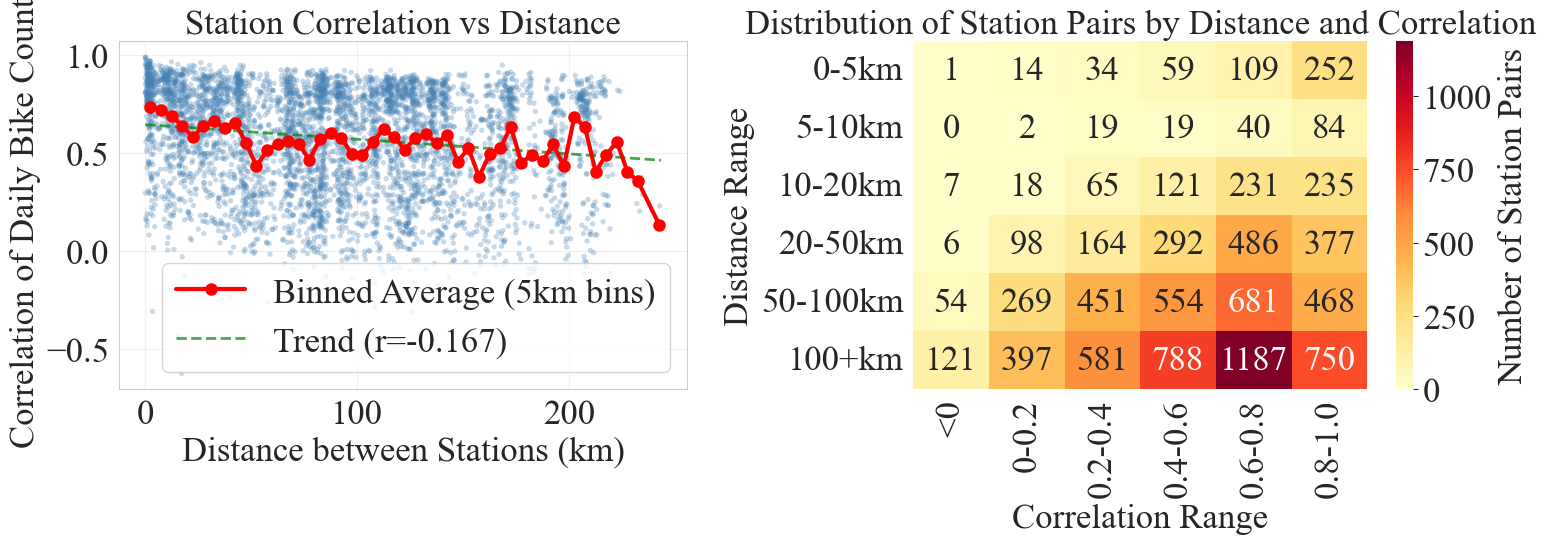


Key findings:
  - Total station pairs: 9,034
  - Mean distance: 90.4 km
  - Mean correlation: 0.577
  - Correlation between distance and bike count correlation: -0.167

Average correlation by distance range:
  - 0-5km: 0.737 (n=469)
  - 5-10km: 0.719 (n=164)
  - 10-20km: 0.662 (n=677)
  - 20-50km: 0.619 (n=1423)
  - 50-100km: 0.537 (n=2477)
  - 100+km: 0.547 (n=3824)


In [29]:
################################################
# Visualize Correlation vs Distance            #
################################################

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot with binned averages
ax = axes[0]

# Sample if too many points
if len(corr_dist_df) > 5000:
    sample_df = corr_dist_df.sample(n=5000, random_state=42)
else:
    sample_df = corr_dist_df

scatter = ax.scatter(sample_df['distance_km'], 
                     sample_df['correlation'],
                     alpha=0.3, s=15, c='steelblue', edgecolors='none')

# Add binned average line
distance_bins = np.arange(0, corr_dist_df['distance_km'].max() + 5, 5)
corr_dist_df['distance_bin'] = pd.cut(corr_dist_df['distance_km'], bins=distance_bins)
binned_avg = corr_dist_df.groupby('distance_bin', observed=True)['correlation'].mean()

bin_centers = [(interval.left + interval.right) / 2 for interval in binned_avg.index]
ax.plot(bin_centers, binned_avg.values, 'r-', linewidth=3, marker='o', 
        markersize=8, label='Binned Average (5km bins)', zorder=5)

ax.set_xlabel('Distance between Stations (km)')
ax.set_ylabel('Correlation of Daily Bike Counts')
ax.set_title('Station Correlation vs Distance')
ax.grid(True, alpha=0.3)
ax.legend()

# Add trend line
z = np.polyfit(corr_dist_df['distance_km'], corr_dist_df['correlation'], 1)
p = np.poly1d(z)
dist_range = np.linspace(corr_dist_df['distance_km'].min(), 
                         corr_dist_df['distance_km'].max(), 100)
ax.plot(dist_range, p(dist_range), 'g--', alpha=0.7, linewidth=2, 
        label=f'Trend (r={overall_corr:.3f})')
ax.legend()

# Plot 2: Heatmap of distance bins vs correlation
ax = axes[1]

# Create distance categories
distance_categories = pd.cut(corr_dist_df['distance_km'], 
                             bins=[0, 5, 10, 20, 50, 100, 500],
                             labels=['0-5km', '5-10km', '10-20km', '20-50km', '50-100km', '100+km'])
corr_dist_df['distance_category'] = distance_categories

# Create correlation categories
corr_categories = pd.cut(corr_dist_df['correlation'],
                         bins=[-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
                         labels=['<0', '0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0'])
corr_dist_df['corr_category'] = corr_categories

# Count pairs in each category
heatmap_data = pd.crosstab(corr_dist_df['distance_category'], 
                            corr_dist_df['corr_category'])

sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Number of Station Pairs'})
ax.set_xlabel('Correlation Range')
ax.set_ylabel('Distance Range')
ax.set_title('Distribution of Station Pairs by Distance and Correlation')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nKey findings:")
print(f"  - Total station pairs: {len(corr_dist_df):,}")
print(f"  - Mean distance: {corr_dist_df['distance_km'].mean():.1f} km")
print(f"  - Mean correlation: {corr_dist_df['correlation'].mean():.3f}")
print(f"  - Correlation between distance and bike count correlation: {overall_corr:.3f}")
print(f"\nAverage correlation by distance range:")
for cat in distance_categories.cat.categories:
    cat_data = corr_dist_df[corr_dist_df['distance_category'] == cat]
    if len(cat_data) > 0:
        print(f"  - {cat}: {cat_data['correlation'].mean():.3f} (n={len(cat_data)})")